# Description

Using CIFAR-10 dataset of 32x32 images in 10 categories, I will:
  * For each category, compute the mean image and the first 20 principal components. Plot the error resulting from representing the images of each category using the first 20 principal components against the category.
  * Compute the distances between mean images for each pair of classes. Use **principal coordinate analysis** to make a 2D map of the means of each categories.
  * Use principal coordinate analysis to make a 2D map of the classes and compare this map to the previous map
  
---

# Imports

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import time
import os
from sklearn.decomposition import TruncatedSVD

# Data

CIFAR-10 is a dataset of 32x32 images in 10 categories, collected by Alex Krizhevsky, Vinod Nair, and Geoffrey Hinton. It is often used to evaluate machine learning algorithms. You can download this dataset from https://www.cs.toronto.edu/~kriz/cifar.html.

* **Input/Output**: This data has a set of 32 pixel rows, 32 pixel columns, and 3 color channels. Therefore, each single image, is vectorized, will consist of $32\times32\times3$ elements (i.e., each image has 3072 dimensions). There are a total of 60000 samples labelled from 10 class. The data set is balanced with each class having exactly 6000 samples.
* **Missing Data**: There is no missing data.
* **Final Goal**: Understand the data using multi-dimensional scaling methods.

In [2]:
import torchvision
import shutil
data_train = torchvision.datasets.CIFAR10('Data/cifar10', train=True, transform=None, target_transform=None, download=True)
data_eval = torchvision.datasets.CIFAR10('Data/cifar10', train=False, transform=None, target_transform=None, download=True)
shutil.rmtree('Data/cifar10/')
train_images_raw = data_train.data
train_labels = np.array(data_train.targets)
eval_images_raw = data_eval.data
eval_labels = np.array(data_eval.targets)
np.savez('Data/cifar10.npz', train_images_raw=train_images_raw, train_labels=train_labels, 
         eval_images_raw=eval_images_raw, eval_labels=eval_labels)

Extracting Data/cifar10\cifar-10-python.tar.gz to Data/cifar10
Files already downloaded and verified


In [3]:
class_to_idx = {'airplane': 0,
                'automobile': 1,
                'bird': 2,
                'cat': 3,
                'deer': 4,
                'dog': 5,
                'frog': 6,
                'horse': 7,
                'ship': 8,
                'truck': 9}

In [4]:
images_raw = np.concatenate([train_images_raw, eval_images_raw], axis=0)
labels = np.concatenate([train_labels, eval_labels], axis=0)
images_raw.shape, labels.shape

((60000, 32, 32, 3), (60000,))

---
# Principal Component Analysis
0. Let's say we have Data Matrix $X$ with $N$ rows (i.e., data points) and $d$ columns (i.e., features).
$$X = [\cdots]_{N \times d}$$
1. Let's perform SVD on the $X$.
$$X=U_x S_x V_x^T$$
Let's assume $N>d$ (We have 6000 data points per class, which is more than the 3072 dimenstions).

By the way SVD works, we should have
$$U_x = [\cdots]_{N \times d}$$
$$S_x = [\cdots]_{d \times d}$$
$$V_x = [\cdots]_{d \times d}$$
and
$$U_x^T U_x = I_{d\times d}$$
$$V_x^T V_x = I_{d\times d}$$

2. We need the following decomposition for the covariance matrix $\Sigma$:
$$\Sigma \mathcal{U} = \mathcal{U} \Lambda$$
3. We assume that X has mean zero (i.e., we already subtracted the feature averages). If $X$ has $N$ rows (i.e., data items), we have
$$\Sigma = \frac{1}{N} X^TX$$
4. Let's find $\Sigma$ in terms of $U_x$, $S_x$, and $V_x$
$$\Sigma = \frac{1}{N} X^TX = \frac{1}{N} V_x S_x U_x^T U_x S_x V_x^T = V_x \frac{S_x^2}{N} V_x^T$$
$$\Rightarrow \Sigma V_x = V_x \frac{S_x^2}{N}$$
5. By comparison, we have
$$\mathcal{U} = V_x$$
$$\Lambda = \frac{S_x^2}{N}$$

### Considering the above:
1. **There is no need to compute the covariance matrix $\Sigma$** and then find its diagonalization; I can easily perform SVD on the data matrix $X$, and get what I need!
2. In fact, I do not even need the matrices $V_x$ and $U_x$ for computing the mean squared error; I can infer the mean squared error using only the $S_x$ matrix. 

## Mean squared error

Function `pca_mse` takes two arguments as input

1. `data_raw`: a numpy array with the shape $(N, \cdots)$, where $N$ is the number of samples, and there may be many excess dimensions denoted by $\cdots$. I will have to reshape this input `data_raw` matrix to obtain a shape of $(N, d)$, where $d$ is the vectorized data's dimension. 
2. `num_components`: This is the number of PCA components that we want to retain. 

and returns the variable `mse` which is the mean squared error of the PCA projection into the designated number of principal components.

In [5]:
def pca_mse(data_raw, num_components=20):
    # Get shape
    N = data_raw.shape[0]
   
    if len(data_raw.shape) > 2:
         # Reshape
        d = (np.prod(data_raw.shape) / data_raw.shape[0]).astype('int')
        data = data_raw.reshape(N, d)
    else:
        d = data_raw.shape[1]
        data = data_raw
        
    # Zero mean
    data_zm = data - np.mean(data, axis=0)
    
    # Apply SVD
    svd = np.linalg.svd(data_zm, compute_uv=False, full_matrices=True)
    
    # Get lambda
    lam = svd**2.0/N
    
    # Compute MSE
    mse = np.sum(lam[num_components:])
    
    return np.float64(mse)

## Compute

In [6]:
class_names = []
class_mses = []
for cls_name, cls_label in class_to_idx.items():
    data_raw = images_raw[labels == cls_label,:,:,:]
    start_time = time.time()
    print(f'Processing Class {cls_name}', end='')
    cls_mse = pca_mse(data_raw, num_components=20)
    print(f' (The SVD operation took %.3f seconds)' % (time.time()-start_time))
    class_names.append(cls_name)
    class_mses.append(cls_mse)

Processing Class airplane (The SVD operation took 14.824 seconds)
Processing Class automobile (The SVD operation took 15.120 seconds)
Processing Class bird (The SVD operation took 16.135 seconds)
Processing Class cat (The SVD operation took 13.925 seconds)
Processing Class deer (The SVD operation took 14.664 seconds)
Processing Class dog (The SVD operation took 13.862 seconds)
Processing Class frog (The SVD operation took 13.952 seconds)
Processing Class horse (The SVD operation took 13.717 seconds)
Processing Class ship (The SVD operation took 14.212 seconds)
Processing Class truck (The SVD operation took 14.007 seconds)


## Vizualise

c:\users\wiewi\appdata\local\programs\python\python37\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


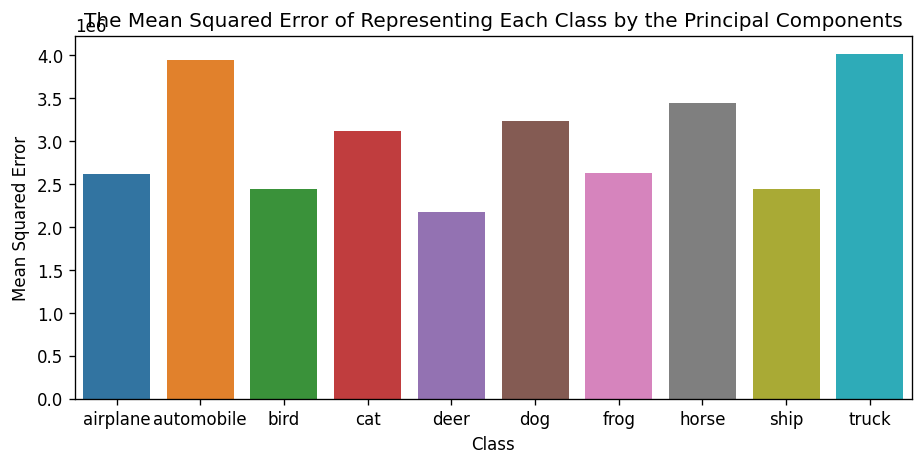

In [7]:
fig, ax = plt.subplots(figsize=(9,4.), dpi=120)
sns.barplot(class_names, class_mses, ax=ax)
ax.set_title('The Mean Squared Error of Representing Each Class by the Principal Components')
ax.set_xlabel('Class')
_ = ax.set_ylabel('Mean Squared Error')

---
# Principal Coordinate Analysis

In [8]:
class_mean_list = []
for cls_label in sorted(class_to_idx.values()):
    data_raw = images_raw[labels == cls_label,:,:,:]
    class_mean = np.mean(data_raw, axis=0).reshape(1,-1)
    class_mean_list.append(class_mean)
class_means = np.concatenate(class_mean_list, axis=0)

Function `mean_image_squared_distances` takes the matrix `class_means` as an input and return the `SquaredDistances` matrix as output.

`class_means` is a numpy array like a traditional data matrix; it has a shape of $(N,d)$ where there are $N$ individual data-points where each is stored in a single $d$ dimensional row.

Function produces the numpy array `SquaredDistances` whose $i^{th}$ row and $j^{th}$ column is the **squared** Euclidean distance between the $i^{th}$ row of `class_means` and $j^{th}$ row of `class_means`. Obviously
* The diagonal elements should be zero.
* The `SquaredDistances` should be symmetric.

In [9]:
def distance(point1, point2):
    return np.linalg.norm(point1 - point2)**2


def mean_image_squared_distances(class_means):
    SquaredDistances = [[distance(i, j) for i in class_means] for j in class_means]
  
    return np.array(SquaredDistances)

I implemented the Principal Coordinate Analysis by writing the function `PCoA` which takes the following arguments:
1. `SquaredDistances`: A numpy array which is square in shape, symmetric, and is the square of a distance matrix of some unknown set of points. The output of the `mean_image_squared_distances` function I wrote previously will be fed as this argument.
2. `r`: This is the dimension of the visualization space.

In [10]:
def PCoA(SquaredDistances, r=2):
    D = SquaredDistances
    N = SquaredDistances.shape[0]
    I = np.identity(N)
    ones = np.ones((N,N))
    
    A = I - (1 / N) * ones
    W = -0.5 * A @ D @ A.T
    
    # lam - eigenvalues; U - eigenvectors
    lam, U = np.linalg.eigh(W)
    
    # Sort in descending
    lam = lam[::-1]
    U = np.fliplr(U)

    Sr = np.diag(np.sqrt(lam[:r]))
    Ur = U[:,:r]
    
    Y = Ur @ Sr
    
    return Y

## Compute

In [11]:
SquaredDistances = mean_image_squared_distances(class_means)
VT = PCoA(SquaredDistances, r=2)

## Vizualise

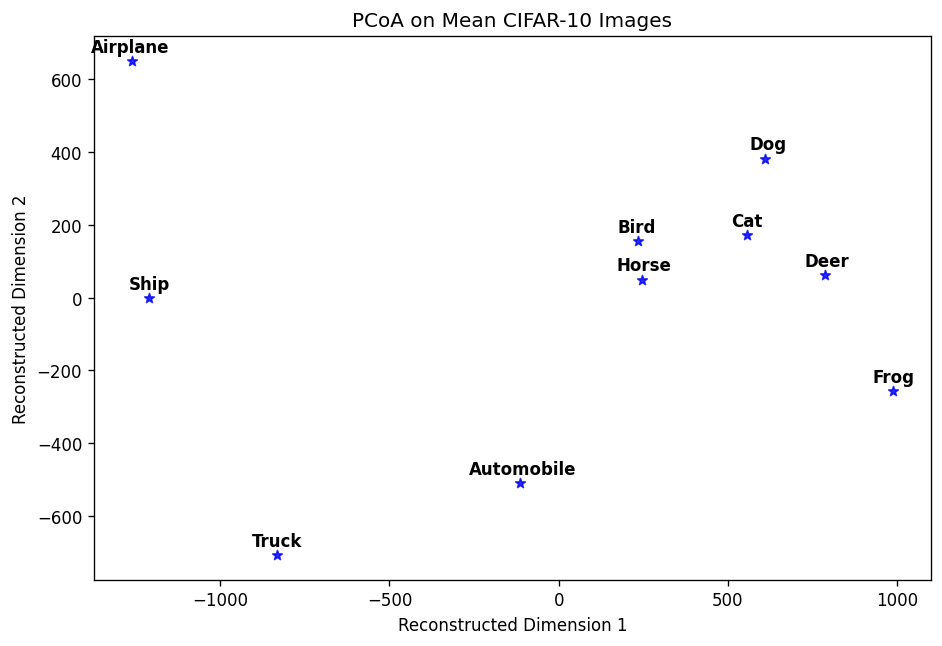

In [12]:
class_names_list = sorted(list(class_to_idx.keys()))
fig, ax = plt.subplots(figsize=(9,6.), dpi=120)
x_components = VT[:,0]
y_components = VT[:,1]
sns.regplot(x=x_components, y=y_components, fit_reg=False, marker="*", color="Blue", ax=ax)
for class_idx in range(VT.shape[0]):
    num_letters = len(class_names_list[class_idx])
    ax.text(x_components[class_idx]-num_letters*15, y_components[class_idx]+25, 
            class_names_list[class_idx].capitalize(), 
            horizontalalignment='left', size='medium', color='black', weight='semibold')
ax.set_xlabel('Reconstructed Dimension 1')
ax.set_ylabel('Reconstructed Dimension 2')
_ = ax.set_title('PCoA on Mean CIFAR-10 Images')

---
# Generalized PCoA with Non-Metric Similarities

Function `principal_components_precise_svd` returns the principal components of a data matrix and takes the following arguments as input

1. `data_raw`: a numpy array with the shape $(N, \cdots)$, where $N$ is the number of samples, and there may be many excess dimensions denoted by $\cdots$. I will have to reshape this input `data_raw` matrix to obtain a shape of $(N, d)$, where $d$ is the vectorized data's dimension.
2. `num_components`: This is the number of PCA components that we want to retain. 

and returns the variable `V_x` which is a numpy array with the shape `(d, num_components)`. The columns are the unitay principal components sorted descendingly with respect to the eigenvalues.

In [13]:
def principal_components_precise_svd(data_raw, num_components=20):
    # Get shape
    N = data_raw.shape[0]
   
    if len(data_raw.shape) > 2:
         # Reshape
        d = (np.prod(data_raw.shape) / data_raw.shape[0]).astype('int')
        data = data_raw.reshape(N, d)
    else:
        d = data_raw.shape[1]
        data = data_raw
    
    # Zero mean
    data_zm = data - np.mean(data, axis=0)
    
    # Apply SVD
    U, S, V_x = np.linalg.svd(data_zm, compute_uv=True)
    V_x = V_x.T[:,:num_components]
    
    sign_unambiguity = np.sign(V_x[np.abs(V_x).argmax(axis=0), np.arange(V_x.shape[1])]).reshape(1,-1)
    V_x *= sign_unambiguity
    return V_x

The following cell will run `principal_components_precise_svd` function on a single class of data, and provide some running time estimate.

In [14]:
first_class_features = images_raw[labels == 0, :, :, :]

starting_time = time.time()
first_class_pcs = principal_components_precise_svd(first_class_features, num_components=20)
end_time = time.time()

print('Finding the principal components on a single class took %.3f seconds.'%(end_time-starting_time))

Finding the principal components on a single class took 27.001 seconds.


Although, this performance is extremely hardware-dependent, it's certainly not negligible. Keep in mind that I will have to run this function about 100 times on data of the same size to construct a similarity matrix in later tasks; any speedup may very well be appreciated.

Most of the computation time in the previous function was spent on the SVD factorization. Essentially, I found all the singular values and directions, ignored most of them, and only kept the top 20. This can be a very good place to start saving on computation; So lets us an efficient SVD variant (sometimes is referred to as the "Truncated SVD" in application). Next I will be a redo of the previous task using this fast factroization.

## Boost performance

Similar to `principal_components_precise_svd`, a function `principal_components` uses `scikit-learn`'s `TruncatedSVD` decomposition instead of the precise `np.linalg.svd` decomposition that was used previously. As before, `principal_components` should return the principal components of a data matrix and take the following arguments as input

1. `data_raw`: a numpy array with the shape $(N, \cdots)$, where $N$ is the number of samples, and there may be many excess dimensions denoted by $\cdots$. I will have to reshape this input `data_raw` matrix to obtain a shape of $(N, d)$, where $d$ is the vectorized data's dimension. 
2. `num_components`: This is the number of PCA components that we want to retain.

`principal_components` returns the variable `V_x` which is a numpy array with the shape `(d, num_components)`. The columns are the unitay principal components sorted descendingly with respect to the eigenvalues.

In [15]:
def principal_components(data_raw, num_components=20):
    # Get shape
    N = data_raw.shape[0]
   
    if len(data_raw.shape) > 2:
         # Reshape
        d = (np.prod(data_raw.shape) / data_raw.shape[0]).astype('int')
        data = data_raw.reshape(N, d)
    else:
        d = data_raw.shape[1]
        data = data_raw
    
    # Zero mean
    data_zm = data - np.mean(data, axis=0)
    
    # Create SVD
    svd = TruncatedSVD(num_components, algorithm='randomized', n_iter=5, random_state=12345)
    
    # Fit SVD
    svd.fit(data_zm)
    
    V_x = svd.components_.T
    
    sign_unambiguity = np.sign(V_x[np.abs(V_x).argmax(axis=0), np.arange(V_x.shape[1])]).reshape(1,-1)
    V_x *= sign_unambiguity
    return V_x

In [16]:
first_class_features = images_raw[labels == 0, :, :, :]

starting_time = time.time()
first_class_pcs = principal_components(first_class_features, num_components=20)
end_time = time.time()

print('Finding the principal components on a single class took %.3f seconds.'%(end_time-starting_time))

Finding the principal components on a single class took 0.607 seconds.


Wow! So much faster.

---

Write the function `E_A_given_B` that computes the $E[A|B]$ and takes the two matrices `class_A_data` and `class_B_data`. 

1. `class_A_data` is a numpy arrays with the shape $(N, \cdots)$, where $N$ is the number of samples, and there may be many excess dimensions denoted by $\cdots$. I will have to reshape this input matrix to obtain a shape of $(N, d)$, where $d$ is the vectorized data's dimension.
2. `class_B_data` has the same data structure as `class_A_data`.

To compute $E[A|B]$:
1. First, reshaping
2. Subtract Class A's mean from its data
3. Use the `principal_components` function I wrote before to extract the 20 principal components of `class_B_data`.
4. Project Class A's data onto the mentioned principal components and get back to the original space.
5. Compute Class A's residuals (i.e., the difference between the original and the projection).
5. Find the squared residual sizes **for each sample**, and then return their mean as the `E_A_cond_B` scalar. In other words, square class A's residuals, sum them over each sample (which should reduce the squared residual matrix to only $N$ elements), and then report the mean of them as `E_A_cond_B`.

In [17]:
def reshape(data):
    # Get shape
    N = data.shape[0]
    
    if len(data.shape) == 2:
        return data
    
    d = (np.prod(data.shape) / data.shape[0]).astype('int')
    return data.reshape(N, d)

def zero_mean(data):
    return data - np.mean(data, axis=0)

In [18]:
def E_A_given_B(class_A_data, class_B_data):
    class_A_data, class_B_data = reshape(class_A_data), reshape(class_B_data)
    # your code here
    
    class_A_data_zm = zero_mean(class_A_data)
    class_B_principal_components = principal_components(class_B_data, 20)
    
    projection = class_A_data_zm @ class_B_principal_components @ class_B_principal_components.T
    
    class_A_residuals = class_A_data_zm - projection
    
    E_A_cond_B = np.mean(np.sum(class_A_residuals**2, axis=1))
    
    return E_A_cond_B

In [19]:
num_classes = class_means.shape[0]
SimilarityMatrix = np.zeros((num_classes, num_classes))
for row in range(num_classes):
    print(f'Row {row}', end='')
    row_st_time = time.time()
    for col in range(row+1):
        class_A_data = images_raw[labels == row, :, :, :]
        class_B_data = images_raw[labels == col, :, :, :]
        E_A_cond_B = E_A_given_B(class_A_data, class_B_data)
        E_B_cond_A = E_A_given_B(class_B_data, class_A_data)
        SimilarityMatrix[col, row] = (E_A_cond_B + E_B_cond_A)/2.
        SimilarityMatrix[row, col] = (E_A_cond_B + E_B_cond_A)/2.
    print(f' (This row took %.3f seconds to finish)'%(time.time() - row_st_time))

Row 0 (This row took 1.805 seconds to finish)
Row 1 (This row took 3.479 seconds to finish)
Row 2 (This row took 5.250 seconds to finish)
Row 3 (This row took 7.670 seconds to finish)
Row 4 (This row took 9.249 seconds to finish)
Row 5 (This row took 10.454 seconds to finish)
Row 6 (This row took 12.094 seconds to finish)
Row 7 (This row took 14.215 seconds to finish)
Row 8 (This row took 15.408 seconds to finish)
Row 9 (This row took 17.085 seconds to finish)


If I apply any general `SimilarityMatrix` variable to the previously defined `PCoA` function, I may get `NaN` entries due to the fact that they may not generally be a metric distance matrix (i.e., having non-zero diagonal elements and the triangle inequality not alway holding).

This issue can be best seen when having a similarity measure that is extremely uneven (i.e., when the small entries are extremely small and the large entries are extremely large). This will make it difficult for the triangle inequality to hold. It is a good idea to ammend the PCoA in a way that can deal with such non-metric similarity measures.

In [20]:
PCoA(SimilarityMatrix**40, r=10)

c:\users\wiewi\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in sqrt


array([[-1.19122359e+131, -1.01273169e+131, -6.64858390e+129,
        -8.41498165e+128,  2.66572612e+123,              nan,
                     nan,              nan,              nan,
                     nan],
       [-1.89955534e+132, -2.69508986e+131, -2.99388280e+126,
        -2.89402196e+125,  2.66572612e+123,              nan,
                     nan,              nan,              nan,
                     nan],
       [-1.22403442e+131, -5.41618003e+130,  1.22455240e+129,
         1.03543307e+129,  2.66572612e+123,              nan,
                     nan,              nan,              nan,
                     nan],
       [ 1.13544520e+131,  2.36886946e+130,  1.23040415e+129,
        -1.24137369e+129,  2.66572612e+123,              nan,
                     nan,              nan,              nan,
                     nan],
       [-1.29411460e+131, -5.17027543e+130,  2.17747099e+129,
         2.70985016e+129,  2.66572612e+123,              nan,
                     nan

Function `Lingoes_PreProcessing` does some pre-processing to the `SimilarityMatrix` to make it have the Euclidean property and the triangles to close.

Here is a very brief and to the point description from the r documentation page (https://www.rdocumentation.org/packages/ape/versions/5.2/topics/pcoa).

"In the Lingoes (1971) procedure, a constant c1, equal to twice absolute value of the largest negative eigenvalue of the original principal coordinate analysis, is added to each original squared distance in the distance matrix, except the diagonal values. A newe principal coordinate analysis, performed on the modified distances, has at most (n-2) positive eigenvalues, at least 2 null eigenvalues, and no negative eigenvalue."

The function `Lingoes_PreProcessing` takes the numpy array `SimilarityMatrix` as input, and returns `ProcessedSimilarityMatrix` based on the following condition:
1. If all eigenvalues computed during PCoA are non-negative, then `ProcessedSimilarityMatrix` should be the same as the `SimilarityMatrix`.
2. Otherwise, follow the instructions to perform the Lingoes correction on the `SimilarityMatrix` and return `ProcessedSimilarityMatrix`.

In other words:
  1. Perform the PCoA analysis on `SimilarityMatrix` right up to the point where we find the eigenvalues, and not any further. More precisely, we should only find the eigenvalues of the matrix $\mathcal{W}$ corresponding to `SimilarityMatrix` in the PCoA analysis.
  2. Find the minimum eigenvalue and call it $\lambda_{\min}$.
  3. If $\lambda_{\min}\geq 0$, then stop and return `SimilarityMatrix` as it was without any change.
  4. If $\lambda_{\min} < 0$, then add  $2|\lambda_{\min}|$ to all the non-diagonal elements of `SimilarityMatrix` and return the resulting matrix.

In [21]:
def Lingoes_PreProcessing(SimilarityMatrix):
    N = SimilarityMatrix.shape[0]
    I = np.identity(N)
    ones = np.ones((N,N))

    A = I - (1 / N) * ones
    W = -0.5 * A @ SimilarityMatrix @ A.T

    # lam - eigenvalues; U - eigenvectors
    lam, U = np.linalg.eigh(W)

    lam_min = np.min(lam)

    if lam_min >= 0:
        return SimilarityMatrix
    
    ProcessedSimilarityMatrix = SimilarityMatrix + (2 * np.abs(lam_min))
    ProcessedSimilarityMatrix[np.diag_indices_from(SimilarityMatrix)] -= (2 * np.abs(lam_min))
    
    return ProcessedSimilarityMatrix

In [22]:
def PCoA_lingoes(SimilarityMatrix, r=2):
    ProcessedSimilarityMatrix = Lingoes_PreProcessing(SimilarityMatrix)
    return PCoA(ProcessedSimilarityMatrix, r=r)

In [23]:
PCoA_lingoes(SimilarityMatrix, r=2)

array([[-119.98786571,  355.24236881],
       [-407.7649715 , -194.47481966],
       [ 200.74413716,   69.91510988],
       [ 228.74930337, -150.11666377],
       [  34.48668888,  156.6042217 ],
       [ 343.06053853, -112.88238769],
       [ 112.75711242,  -44.2970879 ],
       [ 147.41580395,   23.49865708],
       [-290.00131424,  180.85368172],
       [-249.45943287, -284.34308017]])

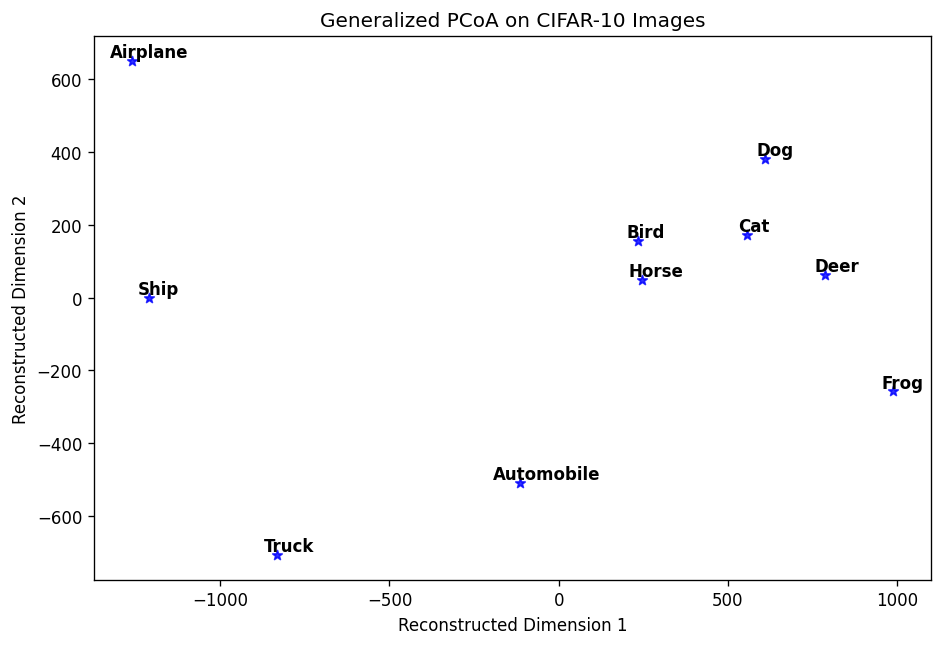

In [24]:
class_names_list = sorted(list(class_to_idx.keys()))
fig, ax = plt.subplots(figsize=(9,6.), dpi=120)
x_components = VT[:,0]
y_components = VT[:,1]
sns.regplot(x=x_components, y=y_components, fit_reg=False, marker="*", color="Blue", ax=ax)
for class_idx in range(VT.shape[0]):
    num_letters = len(class_names_list[class_idx])
    ax.text(x_components[class_idx]-num_letters*8, y_components[class_idx]+10, 
            class_names_list[class_idx].capitalize(), 
            horizontalalignment='left', size='medium', color='black', weight='semibold')
ax.set_xlabel('Reconstructed Dimension 1')
ax.set_ylabel('Reconstructed Dimension 2')
_ = ax.set_title('Generalized PCoA on CIFAR-10 Images')